<a href="https://colab.research.google.com/github/giovadg/physnum_CUDA/blob/main/waves_pde/Exercise_pde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
!wget https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/ach.h -nv -O ach.h
!wget https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/nvtx3.hpp -nv -O nvtx3.hpp
!wget https://github.com/giovadg/physnum_CUDA/tree/main/waves_pde/ConfigFile.h -nv -O ConfigFile.h
!wget https://github.com/giovadg/physnum_CUDA/tree/main/waves_pde/ConfigFile.hpp -nv -O ConfigFile.hpp
!wget https://github.com/giovadg/physnum_CUDA/tree/main/waves_pde/input -nv -O input

2025-12-02 11:30:43 URL:https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/ach.h [5329/5329] -> "ach.h" [1]
2025-12-02 11:30:43 URL:https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/nvtx3.hpp [105839/105839] -> "nvtx3.hpp" [1]
2025-12-02 11:30:44 URL:https://github.com/giovadg/physnum_CUDA/blob/main/waves_pde/ConfigFile.h [192366] -> "ConfigFile.h" [1]
2025-12-02 11:30:45 URL:https://github.com/giovadg/physnum_CUDA/blob/main/waves_pde/ConfigFile.hpp [200562] -> "ConfigFile.hpp" [1]
2025-12-02 11:30:46 URL:https://github.com/giovadg/physnum_CUDA/blob/main/waves_pde/input [186009] -> "input" [1]


In [ ]:
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub > /dev/null 2>&1
!sudo add-apt-repository -y "deb https://developer.download.nvidia.com/devtools/repos/ubuntu$(source /etc/lsb-release; echo "$DISTRIB_RELEASE" | tr -d .)/$(dpkg --print-architecture)/ /" > /dev/null 2>&1
!sudo apt install -y nsight-systems > /dev/null 2>&1
!sudo apt update -qq
!sudo apt install -y nsight-systems-cli

57 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
W: https://developer.download.nvidia.com/devtools/repos/ubuntu2204/amd64/Release.gpg: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  nsight-systems-cli-2025.6.1
The following NEW packages will be installed:
  nsight-systems-cli nsight-systems-cli-2025.6.1
0 upgraded, 2 newly installed, 0 to remove and 57 not upgraded.
Need to get 207 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/devtools/repos/ubuntu2204/amd64  nsight-systems-cli-

In [ ]:
# !nvcc -o /tmp/a.out --extended-lambda Sources/port-thrust-to-gpu.cpp -x cu -arch=native # build executable
# !/tmp/a.out # run executable

In [ ]:
%%writefile script.cpp
#include <iostream>
#include <vector>
#include <fstream>
#include <cmath>
#include <numeric>
#include <cstdlib>
#include <cstdio>
#include <algorithm>
#include <chrono>
#include <string.h>
#include "ConfigFile.h"
#include "ach.h"
#include "nvtx3.hpp"

using namespace std;

const double PI = 3.1415926535897932384626433832795028841971e0;
const double g  = 9.81;

enum state { STATIC=1, RIGHT=2, LEFT=3};
enum bc_type { FIXED=1, FREE=2, EXIT=3};
enum eq_type { EQ_1=1, EQ_6=2};
enum modes { MODE=1, FORCE=2};


unordered_map<std::string, state> initial_state_dic{
  {"static", STATIC},
  {"right",  RIGHT},
  {"left",   LEFT}
};
unordered_map<std::string, eq_type> select_equation{
  {"Eq1", EQ_1},
  {"Eq6",  EQ_6}
};
unordered_map<std::string, bc_type> bc_dic{
  {"fixed", FIXED},
  {"free",  FREE},
  {"exit",  EXIT}
};
unordered_map<std::string, modes> initial_map{{"mode", MODE},{"force", FORCE}};



__global__ void boundary_condition_cuda(double* fnext,  const double* fnow_d, const double* beta2, int bc_l, int bc_r, int N)
{
    if (threadIdx.x != 0 || blockIdx.x != 0) return;
    // Left BC
    if (bc_l == FIXED) {                // fixed
        fnext[0] = 0.0;
    } else if (bc_l == FREE) {         // free
        fnext[0] = fnext[1];
    } else if (bc_l == EXIT) {         // exit
        fnext[0] = fnow_d[0] + (fnow_d[1] - fnow_d[0]) * sqrt(beta2[0]);
    }

    // Right BC
    if (bc_r == FIXED) {                // fixed
        fnext[N-1] = 0.0;
    } else if (bc_r == FREE) {         // free
        fnext[N-1] = fnext[N-2];
    } else if (bc_r == EXIT) {         // exit
        fnext[N-1] = fnow_d[N-1] + (fnow_d[N-2] - fnow_d[N-1]) * sqrt(beta2[N-1]);
    }
}


void boundary_condition(double* fnext, double* fnow_d,
            double* beta2, string &bc_l, string &bc_r, int &N){

  if (bc_l == "fixed"){
    fnext[0] = 0;
  }else if(bc_l == "free"){
    fnext[0] = fnext[1];
  }else if (bc_l =="exit"){
    fnext[0] = fnow_d[0] + (fnow_d[1]-fnow_d[0])*sqrt(beta2[0]);
  }else{
     cerr << "Choose a valid boundary condition for the left part of the domain" << endl;
    }

  if (bc_r == "fixed"){
    fnext[N-1] = 0;
  }else if(bc_r == "free"){
    fnext[N-1] = fnext[N-2];
  }else if (bc_r =="exit"){
    fnext[N-1] = fnow_d[N-1] + (fnow_d[N-2] - fnow_d[N-1]) * sqrt(beta2[N-1]);
  }else{
    cerr << "Choose a valid boundary condition for the right part of the domain" << endl;
  }
  }




__host__ __device__ double finit(double x, double xL, double n_init, double xR, double A, double x1, double x2, int initialization)
{
  double finit_(0.);
  enum modes {MODE=1};

if(initialization==MODE){
  finit_ = sin((n_init + 0.5) * PI * (x - xL) /(xR-xL));
}
else{
  finit_ = A*0.5*(1-cos(2.0 * PI * (x - x1)/(x2 -x1)))*(x1<x && x<x2) ;
}
  return finit_;
}

template <class T> ostream& operator<< (ostream& o, vector<T> const& v)
{
  unsigned int len(v.size());
  for(unsigned int i(0); i < (len - 1); ++i)
    o << v[i] << " ";
  if(len > 0)
    o << v[len-1];
  return o;
}


int main(int argc, char* argv[])
{
  double dx, dt, t;
  int stride(0), N, initial_state_int, initialization, equation_type;
  vector<double> step_duration_writ;

  string inputPath("input"); // default input file
  if(argc>1) // input file specified by the user ("./exe config_perso.in")
    inputPath = argv[1];

  ConfigFile configFile(inputPath); // Parameters are read and put in a map

  for(int i(2); i<argc; ++i) // Additional inputs (needed for scan of parameters) ("./Exercice7 config_perso.in input_scan=[value]")
    configFile.process(argv[i]);

  // Simulation parameters :
  int nx                    = configFile.get<int>("nx",64); // nb intervalles
  int n_stride              = configFile.get<int>("n_stride",10);

  double tfin                  = configFile.get<double>("tfin",10);
  double CFL                   = configFile.get<double>("CFL",1);
  double nsteps                = configFile.get<double>("nsteps",3);
  double A                     = configFile.get<double>("A",1);
  double n_init                = configFile.get<double>("n_init",3);
  double hL                    = configFile.get<double>("hL",7000);
  double hR                    = configFile.get<double>("hR",200);
  double hC                    = configFile.get<double>("hC",35);
  double h00                   = configFile.get<double>("h00",3);
  double x1                    = configFile.get<double>("x1",2.0);
  double x2                    = configFile.get<double>("x2",6.0);
  double xa                    = configFile.get<double>("xa",3*pow(10,5));
  double xb                    = configFile.get<double>("xb",7*pow(10,5));
  double xc                    = configFile.get<double>("xc",7.2*pow(10,5));
  double xd                    = configFile.get<double>("xd",8.5*pow(10,5));
  double xL                    = configFile.get<double>("xL",0);
  double xR                    = configFile.get<double>("xR",10.0);
  bool impose_nsteps           = configFile.get<bool>("impose_nsteps",false);
  bool v_uniform               = configFile.get<bool>("v_uniform",true);
  bool usecub                  = configFile.get<bool>("usecub",true);
  bool bc_cuda                 = configFile.get<bool>("bc_cuda",true);
  bool swap_bool               = configFile.get<bool>("swap_bool",true);
  bool thrust_device           = configFile.get<bool>("thrust_device",true);
  bool ecrire_f                = configFile.get<bool>("ecrire_f",true);
  string equation_type_str     = configFile.get<string>("equation_type","Eq1");
  string bc_l_str              = configFile.get<string>("cb_gauche","free");
  string bc_r_str              = configFile.get<string>("cb_droite","free");
  string initialization_string = configFile.get<string>("initialization","mode");
  string initial_state         = configFile.get<string>("initial_state","static");
  string output                = configFile.get<string>("output","outputout");

  N = nx+1;                                // pts of the mesh
  dx = (xR - xL) / (N-1);

  initial_state_int = initial_state_dic[initial_state];
  initialization    = initial_map[initialization_string];
  equation_type     = select_equation[equation_type_str];
  auto bc_l         = bc_dic[bc_l_str];
  auto bc_r         = bc_dic[bc_r_str];

  vector<double> fnow_h(N);
  thrust::universal_vector<double> h0(N) ;
  thrust::universal_vector<double> vel2(N) ;
  thrust::universal_vector<double> x(N) ;
  thrust::universal_vector<double> fpast(N), fnext(N), fnow_d(N), beta2(N);

  auto step_begin = chrono::high_resolution_clock::now();

  for(int i(0); i<N; ++i){
     x[i] = xL + i * dx ;
     h0[i] = 0.0;
     if(v_uniform){
           h0[i]  = h00;
     }
     else {
           h0[i]  = hL * (xL<=x[i] && x[i]<=xa) + \
		   (0.5*(hL + hC) + 0.5*(hL - hC)*cos(PI *(x[i]-xa)/(xb - xa))) * (xa<x[i] && x[i]<xb) +\
          hC * (xb<=x[i] && x[i]<=xc) + \
		   (0.5*(hR + hC) - 0.5*(hR - hC)*cos(PI *(x[i]-xc)/(xd - xc))) * (xc<x[i] && x[i]<xd) +\
		     hR * (xd<=x[i] && x[i]<=xR);

	   if(i==0) cout << "v is not uniform"<<endl;
     }
     vel2[i]  = g* h0[i];
  }

  auto max_vel2 = std::max_element(vel2.begin(), vel2.end());
  dt = CFL * dx / sqrt(*max_vel2);

  if(impose_nsteps){
    dt  = tfin/nsteps;
    CFL = dt/dx * sqrt(*max_vel2);
  }

  // prepare the output files, for the mesh, the velocity and the wave
  ofstream fichier_x((output + "_x").c_str());
  fichier_x.precision(15);

  ofstream fichier_v((output + "_v").c_str());
  fichier_v.precision(15);

  ofstream fichier_f((output + "_f").c_str());
  fichier_f.precision(15);


  double* x_ptr    = thrust::raw_pointer_cast(x.data());
  double* vel2_ptr = thrust::raw_pointer_cast(vel2.data());

  auto function = [=] __device__ __host__ (int i) {

      double beta = vel2_ptr[i] * dt * dt / (dx * dx);
      double fnow_d = finit(x_ptr[i],  xL,  n_init,  xR, A, x1, x2, initialization);
      double fpast_init;

      if(initial_state_int == STATIC){
          fpast_init = fnow_d;
      }
      else if(initial_state_int == RIGHT){
          fpast_init = finit(x_ptr[i] + sqrt(vel2_ptr[i]) * dt,
                        xL, n_init, xR, A, x1, x2, initialization);
      }
      else { // LEFT
          fpast_init = finit(x_ptr[i] - sqrt(vel2_ptr[i]) * dt,
                        xL, n_init, xR, A, x1, x2, initialization);
      }
      return thrust::make_tuple(beta, fnow_d, fpast_init);
  };

  auto zip_begin = thrust::make_zip_iterator(
      thrust::make_tuple(beta2.begin(), fnow_d.begin(), fpast.begin())
  );

  auto zip_end = zip_begin + N;

  thrust::tabulate(thrust::device, zip_begin, zip_end, function);
  if(thrust_device){thrust::tabulate(thrust::device, zip_begin, zip_end, function);}
  else{             thrust::tabulate(thrust::host, zip_begin, zip_end, function);}

  thrust::copy(fnow_d.begin(), fnow_d.end(), fnow_h.begin());

  double* fnow_ptr  = thrust::raw_pointer_cast(fnow_d.data());
  double* fpast_ptr = thrust::raw_pointer_cast(fpast.data());
  double* fnext_ptr = thrust::raw_pointer_cast(fnext.data());
  double* beta2_ptr = thrust::raw_pointer_cast(beta2.data());
  auto input = thrust::make_counting_iterator(0);

  // temporal loop :
  for(t=0.; t<tfin-.5*dt; t+=dt)
  {
    {
      nvtx3::scoped_range r_compute{"compute fnext"};
      auto fun = [=] __device__ __host__ (int i) {
        double fnext(fnow_ptr[i]);
        if (i >0 && i < N-1){
          fnext = 2.*(1.-beta2_ptr[i])*fnow_ptr[i] - fpast_ptr[i] + beta2_ptr[i]*(fnow_ptr[i+1]+fnow_ptr[i-1]); // TODO : Compléter le schéma A
          if(equation_type == EQ_1){
            fnext += .25*(beta2_ptr[i+1]-beta2_ptr[i-1])*(fnow_ptr[i+1]-fnow_ptr[i-1]); // TODO : Compléter le schéma B
          }else if(equation_type == EQ_6){  // part facultatif
            fnext += .5*(beta2_ptr[i+1]-beta2_ptr[i-1])*(fnow_ptr[i+1]-fnow_ptr[i-1]) + (beta2_ptr[i+1]-2.*beta2_ptr[i]+beta2_ptr[i-1])*fnow_ptr[i]; // TODO : Compléter le schéma C
          }
        }
        return fnext;
      };

      // aync versus sync call
      if(usecub){
        if (t<dt){printf("using cub \n");}
        cub::DeviceTransform::Transform(input, fnext.begin(), N, fun);
      }else{
        if (t<dt){printf("using thrust \n");}
        if(thrust_device){ thrust::tabulate(thrust::device, fnext.begin(), fnext.end(), fun);}
        else{              thrust::tabulate(thrust::host, fnext.begin(), fnext.end(), fun);}

      }
    }
    if(bc_cuda){
      boundary_condition_cuda<<<1,1>>>(fnext_ptr, fnow_ptr, beta2_ptr, bc_l, bc_r, N);
    }else{
      boundary_condition(fnext_ptr, fnow_ptr, beta2_ptr, bc_l_str, bc_r_str, N);
    }
    {
      nvtx3::scoped_range r_update{"update vectors"};
      if (swap_bool){
          fpast.swap(fnow_d);
          fnow_d.swap(fnext);
          // with swap pointers must be re-defined
          fnow_ptr  = thrust::raw_pointer_cast(fnow_d.data());
          fpast_ptr = thrust::raw_pointer_cast(fpast.data());
          fnext_ptr = thrust::raw_pointer_cast(fnext.data());

      } else {
          thrust::copy(fnow_d.begin(), fnow_d.end(), fpast.begin());
          thrust::copy(fnext.begin(),  fnext.end(),  fnow_d.begin());
      }
    }

    {
      nvtx3::scoped_range r_write{"write on disk"};
      if(stride % n_stride == 0){
        cudaDeviceSynchronize();
        thrust::copy(fnow_d.begin(), fnow_d.end(), fnow_h.begin());
        if(ecrire_f) fichier_f << t << " " << fnow_h << endl;
      }
      ++stride;
    }



  }
  auto step_end = std::chrono::high_resolution_clock::now();
  auto step_seconds = std::chrono::duration<double>(step_end - step_begin).count();

  printf("\n");
  printf("Total elapsed time computation is %g [s] \n", step_seconds);

  if(ecrire_f) fichier_f << t << " " << fnow_h << endl;
  fichier_x << x_ptr << endl;
  fichier_v << vel2_ptr << endl;

  fichier_f.close();
  fichier_x.close();
  fichier_v.close();

  return 0;
}


Writing script.cpp


In [ ]:
# !nvcc -x cu test.cpp -o --extended-lambda <b.out
!nvcc -o /tmp/b_gpu.out --extended-lambda script.cpp -x cu -arch=native # build executable

In [ ]:
!nsys profile --cuda-event-trace=false --force-overwrite true -o script_profiled /tmp/b_gpu.out input # run and profile executable


	nx=128
	n_stride=2
	tfin=1.05334
	CFL=1
	nsteps=100
	A=1
	n_init=3
	hL=7000
	hR=200
	hC=35
	h00=3
	x1=2
	x2=6
	xa=300000
	xb=700000
	xc=720000
	xd=850000
	xL=0
	xR=10
	impose_nsteps=0
	v_uniform=1
	usecub=1
	bc_cuda=1
	swap_bool=1
	thrust_device=1
	ecrire_f=1
	equation_type=Eq1
	cb_gauche=fixed
	cb_droite=free
	initialization=mode
	initial_state=static
	output=test.out
using cub 

Total elapsed time computation is 0.00629511 [s] 
Generating '/tmp/nsys-report-e5a6.qdstrm'
[1/1] [========================100%] script_profiled.nsys-rep
Generated:
	/content/script_profiled.nsys-rep


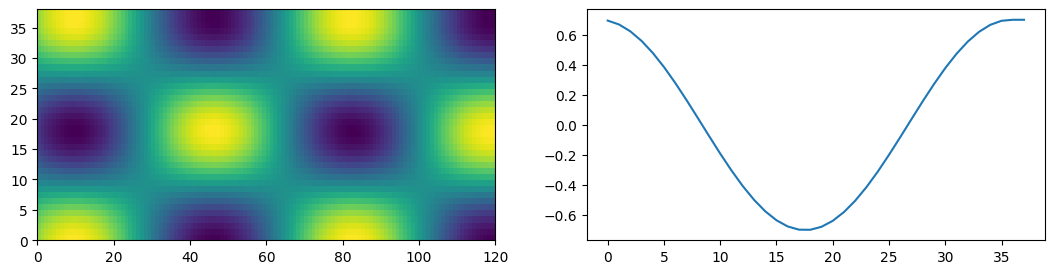

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('test.out_f')

fig, ax = plt.subplots(ncols=2, figsize=(13, 3))
ax[0].pcolor(data[:, 10:], shading='auto')
ax[1].plot(data[:,10])